In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from traitlets import validate
import sklearn.model_selection
import numpy as np
import tensorflow as tf
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# in this part i will read data using image_data_generator******

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

train_dir = '/kaggle/input/trhuyjgg/data_set_deep/dataset/train'
validation_dir = '/kaggle/working/validation/'
os.makedirs(validation_dir, exist_ok=True)

train_datagen = ImageDataGenerator(
    rescale=1./255, #normalize_pixeils
    validation_split=0.2  #split into 80 train and 20 test
)

target_size = (224,224) #we will work with 224*224 with RGP
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)


Found 7920 images belonging to 5 classes.
Found 1980 images belonging to 5 classes.


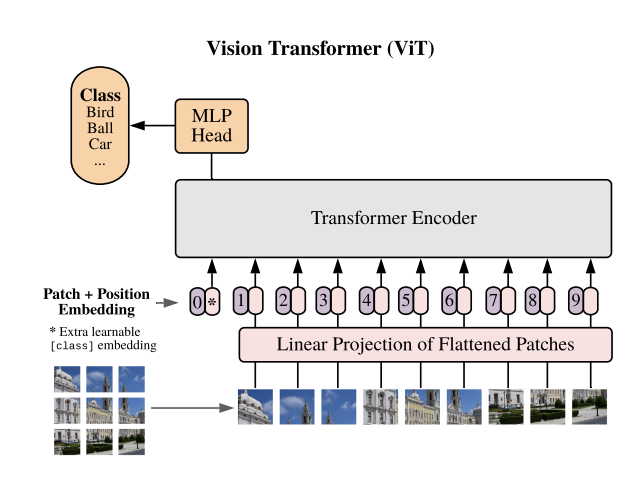# **WE Will build Vision Transform  from scratch based on kers.documenation by Alexey Dosovitskiy**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def multi_head_self_attention(x, embed_dim, num_heads):
    # Define multi-head self-attention mechanism
    head_dim = embed_dim // num_heads
    assert head_dim * num_heads == embed_dim, "Embedding dimension must be divisible by the number of heads."

    def scaled_dot_product_attention(q, k, v):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights

    # Apply attention mechanism to input tensor
    q = layers.Dense(embed_dim)(x)
    k = layers.Dense(embed_dim)(x)
    v = layers.Dense(embed_dim)(x)

    q = tf.reshape(q, (-1, tf.shape(q)[1], num_heads, head_dim))
    k = tf.reshape(k, (-1, tf.shape(k)[1], num_heads, head_dim))
    v = tf.reshape(v, (-1, tf.shape(v)[1], num_heads, head_dim))

    q = tf.transpose(q, perm=[0, 2, 1, 3])
    k = tf.transpose(k, perm=[0, 2, 1, 3])
    v = tf.transpose(v, perm=[0, 2, 1, 3])

    attention, _ = scaled_dot_product_attention(q, k, v)

    attention = tf.transpose(attention, perm=[0, 2, 1, 3])
    attention = tf.reshape(attention, (-1, tf.shape(attention)[1], embed_dim))

    output = layers.Dense(embed_dim)(attention)

    return output

def vision_transformer(input_shape, num_classes, embed_dim=256, num_heads=8, ff_dim=2048, num_transformer_blocks=12, mlp_dim=512, dropout_rate=0.1, learning_rate=1e-4):
    # Define the Vision Transformer model

    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Patch creation and processing
    patch_size = 16
    patches = layers.Conv2D(embed_dim, patch_size, strides=patch_size, padding="valid")(inputs)
    patches = layers.BatchNormalization()(patches)
    patches = layers.Activation("swish")(patches)  # Replace with your preferred activation function
    patches = layers.Reshape((-1, embed_dim))(patches)

    # Positional embeddings
    positions = tf.range(start=0, limit=tf.shape(patches)[1], delta=1)
    positions = tf.expand_dims(positions, axis=-1)
    positions = tf.cast(positions, dtype=tf.float32)
    position_embeddings = positions + patches

    # Transformer blocks
    for _ in range(num_transformer_blocks):
        # Attention mechanism
        x1 = layers.LayerNormalization(epsilon=1e-6)(position_embeddings)
        x2 = multi_head_self_attention(x1, embed_dim, num_heads)
        x2 = layers.Dropout(dropout_rate)(x2)
        position_embeddings = x1 + x2

        # Feedforward network
        x3 = layers.LayerNormalization(epsilon=1e-6)(position_embeddings)
        x3 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="swish")(x3)  # Replace with your preferred activation function
        x3 = layers.Dropout(dropout_rate)(x3)
        x3 = layers.Conv1D(filters=embed_dim, kernel_size=1)(x3)
        position_embeddings = position_embeddings + x3

    # Global average pooling and MLP
    x = layers.GlobalAveragePooling1D()(position_embeddings)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(mlp_dim, activation="swish")(x)  # Replace with your preferred activation function
    x = layers.Dropout(0.1)(x)

    # Flatten before the classification head
    x = layers.Flatten()(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # Create and compile the model
    model = models.Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Example usage:
input_shape = (224, 224, 3)
num_classes = 5

# Instantiate the model
vit_model = vision_transformer(input_shape, num_classes, learning_rate=1e-4)

# Print model summary
vit_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 256)          196864    ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 14, 14, 256)          1024      ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 14, 14, 256)          0         ['batch_normalization[0][0

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = vit_model.fit(train_generator, epochs=200, validation_data=(validation_generator), callbacks=[early_stopping])


Epoch 1/200
248/248 [==============================] - 171s 467ms/step - loss: 1.3609 - accuracy: 0.4394 - val_loss: 1.7577 - val_accuracy: 0.3091
Epoch 2/200
248/248 [==============================] - 116s 468ms/step - loss: 1.1576 - accuracy: 0.5241 - val_loss: 1.5623 - val_accuracy: 0.4222
Epoch 3/200
248/248 [==============================] - 116s 468ms/step - loss: 1.0693 - accuracy: 0.5761 - val_loss: 1.2452 - val_accuracy: 0.4909
Epoch 4/200
248/248 [==============================] - 116s 467ms/step - loss: 1.0121 - accuracy: 0.6043 - val_loss: 1.3542 - val_accuracy: 0.4359
Epoch 5/200
248/248 [==============================] - 116s 468ms/step - loss: 0.9822 - accuracy: 0.6197 - val_loss: 1.1974 - val_accuracy: 0.5126
Epoch 6/200
248/248 [==============================] - 116s 468ms/step - loss: 0.9231 - accuracy: 0.6466 - val_loss: 1.2290 - val_accuracy: 0.5242
Epoch 7/200
248/248 [==============================] - 116s 468ms/step - loss: 0.8864 - accuracy: 0.6645 - val_loss: 1

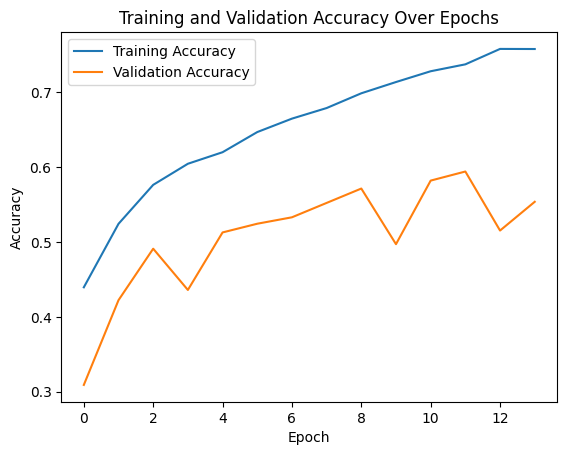

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()